#FC

##Definitions

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from numpy import linalg as LA

##FC implimentation


In [ ]:
!pip install torch-summary
from torchsummary import summary

In [ ]:
class SimpleFC(nn.Module):
  def __init__(self, input_dim , layer_1 , layer_2, output_dim):
    super(SimpleFC, self).__init__()
    #torch.manual_seed(501)
    # random.seed(501)
    #np.random.seed(501)

    self.fc1 = None
    self.fc2 = None
    self.fc3 = None
    self.fc1 =  nn.Linear(input_dim, layer_1)
    self.fc2 =  nn.Linear(layer_1, layer_2)
    self.fc3 =  nn.Linear(layer_2, output_dim)
  def forward(self, x):
    
    x= self.fc1(x)
    x= nn.functional.relu(x)
    x= self.fc2(x)
    x= nn.functional.relu(x)
    x= self.fc3(x)
    x= nn.functional.relu(x)
    ###########################################################
    #                         END OF YOUR CODE                #
    ###########################################################
    return x

##Optimizer

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
def get_training_components(learnable_params, init_lr, step_size=None, gamma=None):
  '''
  Function to prepare components of the training. These are all the same
  throughout the experiments made.
  '''
  # The problem always be a image classification
  criterion = nn.CrossEntropyLoss()
  # Which parameters to be updated depends on if the training is done from scratch
  # or with pre-trained model.
  optimizer = optim.SGD(learnable_params, lr=init_lr, momentum=0.9)
  # Step size depends on the # of epoch
  if step_size is not None:
    scheduler = StepLR(optimizer, step_size, gamma)
    return (criterion, optimizer, scheduler)
  return (criterion, optimizer)

In [ ]:
def get_device():
  if torch.cuda.is_available():
    print("Cuda (GPU support) is available and enabled!")
    device = torch.device("cuda")
  else:
    print("Cuda (GPU support) is not available :(")
    device = torch.device("cpu")
device = get_device()

Cuda (GPU support) is not available :(


##Trainer

In [ ]:
def train(model, criterion, optimizer, epochs, dataloader, device, input_dim, scheduler=None, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
  """
  loss_history = [] 
  #validloss_history = []
  misalignments = []
  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):    
      
      # Our batch:
      inputs  = data[:,:input_dim].float() 
      labels  = data[:,input_dim:].long()
      inputs = inputs.to(device)
      labels = labels.to(device)
      #inputs = inputs.to(device)
      #labels = labels.to(device)

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model.forward(inputs)
      #validoutputs = model.forward(validinputs)
      # Calculate loss
      outputs = outputs.to(device)
      #print(outputs.shape)
      #print(labels[:,0].shape)
      loss = criterion(outputs, labels[:,0])
      #valid_loss = criterion(validoutputs, validlabels)
      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_history.append(loss.item())
      #validloss_history.append(valid_loss.item())
      
    if verbose: print(f'Epoch {epoch} / {epochs}: avg. train loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history 

##Training

###Appendix E1, Left Plot


In [ ]:
def get_learnable_parameters(model):
  params_to_update = []
  for name, param in model.named_parameters():
    if param.requires_grad == True:
      # print(name)
      params_to_update.append(param)
  return params_to_update

In [ ]:
input_dim = 10 
layer_1 = 2048
layer_2 = 256
output_dim = 10
data_size = 10000

In [ ]:
A = np.random.randint(output_dim, size=data_size)
#B = np.zeros((data_size, output_dim))
B = np.zeros((data_size, 1))
for i in range(data_size):
  #B[i,A[i]]=1
  B[i,:]=A[i]
Labels = B


In [ ]:
#Cov= np.diag(np.arange(0.1,3.1,0.1))
Cov= np.diag(np.arange(1,2.0,0.1))
Mean = np.zeros(Cov.shape[0])
synthetic_data = np.random.multivariate_normal(Mean, Cov, data_size)

In [ ]:
Data_All = np.zeros((data_size,input_dim+1))
Data_All[:,:input_dim] = synthetic_data
Data_All[:,input_dim:] = Labels

In [ ]:
batch_size = 128
trainloader = torch.utils.data.DataLoader(Data_All, batch_size=batch_size, shuffle=True, num_workers=2)

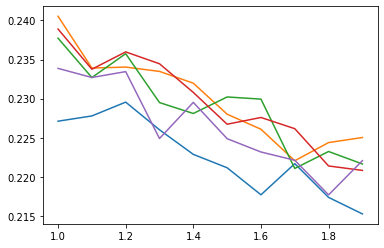

In [ ]:
iteration_no = 5

for i in range(iteration_no):
  FC = SimpleFC(input_dim, layer_1,layer_2,output_dim)
  epochs = 200
  learning_rate = 0.01
  learnable_parameters = get_learnable_parameters(FC)
  criterion, optimizer = get_training_components(learnable_parameters, learning_rate)
  loss_history = train(FC, criterion, optimizer, epochs, trainloader, device, input_dim, verbose=False)
  #PATH = "FC.pt"
  #torch.save(FC, PATH)
  #with open('LossHist_FC.npy', 'wb') as f:
      #np.save(f, loss_history)
  #plt.plot(loss_history)
  ##plt.xlabel('Iteration number')
  #plt.ylabel('Loss value')
  #plt.show()
  Cov_y = np.cov(FC.fc1.weight.detach().numpy().T)
  #plt.plot(np.diag(Cov),np.diag(Cov_y))
  w_x, v_x = LA.eig(Cov)
  plt.plot(np.diag(Cov), np.sqrt(np.diag(np.matmul(np.matmul( v_x.T , Cov_y ), v_x[:])  )))
plt.show()

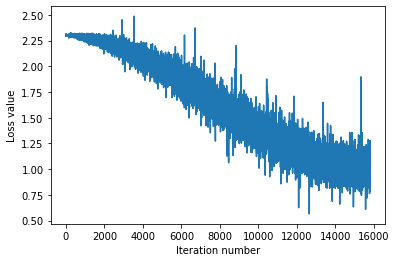

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

###Appendix E1, Middle Plot (Also Figure 4 Left)


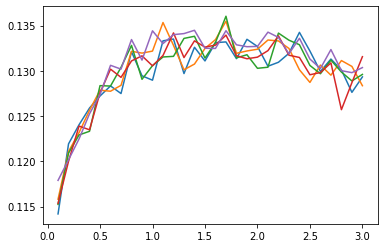

In [ ]:
input_dim = 30 
layer_1 = 2048
layer_2 = 256
output_dim = 10
data_size = 10000

A = np.random.randint(output_dim, size=data_size)
#B = np.zeros((data_size, output_dim))
B = np.zeros((data_size, 1))
for i in range(data_size):
  #B[i,A[i]]=1
  B[i,:]=A[i]
Labels = B

Cov= np.diag(np.arange(0.1,3.1,0.1))
#Cov= np.diag(np.arange(1,2.0,0.1))
Mean = np.zeros(Cov.shape[0])
synthetic_data = np.random.multivariate_normal(Mean, Cov, data_size)

Data_All = np.zeros((data_size,input_dim+1))
Data_All[:,:input_dim] = synthetic_data
Data_All[:,input_dim:] = Labels

batch_size = 128
trainloader = torch.utils.data.DataLoader(Data_All, batch_size=batch_size, shuffle=True, num_workers=2)

iteration_no = 5

for i in range(iteration_no):
  FC = SimpleFC(input_dim, layer_1,layer_2,output_dim)
  epochs = 200
  learning_rate = 0.01
  learnable_parameters = get_learnable_parameters(FC)
  criterion, optimizer = get_training_components(learnable_parameters, learning_rate)
  loss_history = train(FC, criterion, optimizer, epochs, trainloader, device, input_dim,  verbose=False)
  #PATH = "FC.pt"
  #torch.save(FC, PATH)
  #with open('LossHist_FC.npy', 'wb') as f:
      #np.save(f, loss_history)
  #plt.plot(loss_history)
  ##plt.xlabel('Iteration number')
  #plt.ylabel('Loss value')
  #plt.show()
  Cov_y = np.cov(FC.fc1.weight.detach().numpy().T)
  #plt.plot(np.diag(Cov),np.diag(Cov_y))
  w_x, v_x = LA.eig(Cov)
  plt.plot(np.diag(Cov), np.sqrt(np.diag(np.matmul(np.matmul( v_x.T , Cov_y ), v_x[:])  )))
plt.show()

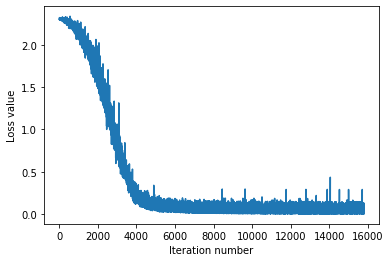

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()


### Appendix E, Right Plot

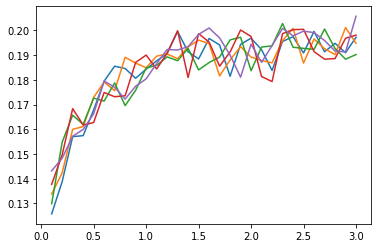

In [ ]:
input_dim = 30 
layer_1 = 256
layer_2 = 256
output_dim = 10
data_size = 2000

A = np.random.randint(output_dim, size=data_size)
#B = np.zeros((data_size, output_dim))
B = np.zeros((data_size, 1))
for i in range(data_size):
  #B[i,A[i]]=1
  B[i,:]=A[i]
Labels = B

Cov= np.diag(np.arange(0.1,3.1,0.1))
#Cov= np.diag(np.arange(1,2.0,0.1))
Mean = np.zeros(Cov.shape[0])
synthetic_data = np.random.multivariate_normal(Mean, Cov, data_size)

Data_All = np.zeros((data_size,input_dim+1))
Data_All[:,:input_dim] = synthetic_data
Data_All[:,input_dim:] = Labels

batch_size = 128
trainloader = torch.utils.data.DataLoader(Data_All, batch_size=batch_size, shuffle=True, num_workers=2)

iteration_no = 5

for i in range(iteration_no):
  FC = SimpleFC(input_dim, layer_1,layer_2,output_dim)
  epochs = 200
  learning_rate = 0.01
  learnable_parameters = get_learnable_parameters(FC)
  criterion, optimizer = get_training_components(learnable_parameters, learning_rate)
  loss_history = train(FC, criterion, optimizer, epochs, trainloader, device, input_dim,  verbose=False)
  #PATH = "FC.pt"
  #torch.save(FC, PATH)
  #with open('LossHist_FC.npy', 'wb') as f:
      #np.save(f, loss_history)
  #plt.plot(loss_history)
  ##plt.xlabel('Iteration number')
  #plt.ylabel('Loss value')
  #plt.show()
  Cov_y = np.cov(FC.fc1.weight.detach().numpy().T)
  #plt.plot(np.diag(Cov),np.diag(Cov_y))
  w_x, v_x = LA.eig(Cov)
  plt.plot(np.diag(Cov), np.sqrt(np.diag(np.matmul(np.matmul( v_x.T , Cov_y ), v_x[:])  )))
plt.show()

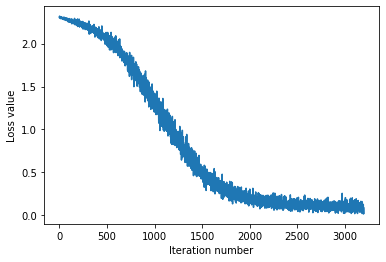

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()


#CNN

##Cifar10 Loader

In [ ]:
def get_cifar10_loaders(batch_size, partial=None, random=None):
  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)
  
  if random is not None:
    temp = np.random.randint(10, size=len(trainset))
    trainset.targets = [int(label) for label in temp]

  if partial is not None:
    indices = np.arange(0,len(trainset))
    np.random.shuffle(indices)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False, num_workers=2, 
                                              sampler=torch.utils.data.SubsetRandomSampler(indices[:partial]))
  else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  return trainloader,trainset, testloader, testset

##CNN Implimentation

In [ ]:
from torch import nn


class SimpleCNN(nn.Module):
  def __init__(self, kernel_size , num_filters, num_units, num_output, img_width, img_height):
    super(SimpleCNN, self).__init__()
    torch.manual_seed(501)
    # random.seed(501)
    np.random.seed(501)

    self.conv1 = None
    self.fc1 = None
    self.fc2 = None
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=num_filters, kernel_size=kernel_size, stride=1,padding=0)
    last_size = (img_width-kernel_size+1) * (img_height-kernel_size+1) * num_filters  # This assumes no padding and stride of 1
    self.fc1 =  nn.Linear(last_size, num_units)
    self.fc2 =  nn.Linear(num_units, num_output)

  def forward(self, x):
    
    x= self.conv1(x)
    x= nn.functional.relu(x)
    x= x.reshape(x.shape[0],x.shape[1]*x.shape[2]*x.shape[3])
    x= self.fc1(x)
    x= nn.functional.relu(x)
    x= self.fc2(x)
    ###########################################################
    #                         END OF YOUR CODE                #
    ###########################################################
    return x

Files already downloaded and verified
Files already downloaded and verified


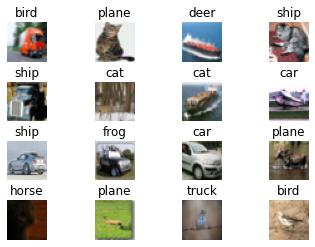

In [ ]:
trainloader,trainset, _ , _= get_cifar10_loaders(256,random=True)

dataiter = iter(trainloader)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
S = 4

for i in range(S):
  for j in range(S):
    images, labels = dataiter.next()
    X = np.transpose(images[0].numpy()/2+0.5, (1, 2, 0))
    y = labels[0]

    plt.subplot(S, S, i*S+j+1)
    plt.imshow(X)
    plt.axis('off')
    plt.title(classes[y])
    plt.subplots_adjust(hspace = 0.5)

plt.show()

In [ ]:
def train(model, criterion, optimizer, epochs, dataloader, device, input_dim, scheduler=None, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
  """
  loss_history = [] 
  #validloss_history = []
  misalignments = []
  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):    
      
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model.forward(inputs)
      #validoutputs = model.forward(validinputs)
      # Calculate loss
      outputs = outputs.to(device)
      #print(outputs.shape)
      #print(labels[:,0].shape)
      loss = criterion(outputs, labels)
      #valid_loss = criterion(validoutputs, validlabels)
      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_history.append(loss.item())
      #validloss_history.append(valid_loss.item())
      
    if verbose: print(f'Epoch {epoch} / {epochs}: avg. train loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history 

In [ ]:
CNN = SimpleCNN(3, 256, 64, 10, 32, 32)

CNN = CNN.to(device)
#simple_cnn.train()
epochs = 40
learning_rate = 0.01
summary(CNN)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            7,168
├─Linear: 1-2                            14,745,664
├─Linear: 1-3                            650
Total params: 14,753,482
Trainable params: 14,753,482
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            7,168
├─Linear: 1-2                            14,745,664
├─Linear: 1-3                            650
Total params: 14,753,482
Trainable params: 14,753,482
Non-trainable params: 0

In [ ]:
from sklearn.feature_extraction import image

def create_patches_data(trainloader, patch_size):
  # 32x32 images in CIFAR10, stride is 1
  num_patches_per_image = ((32 - patch_size + 1)**2)
  # 3 channels  
  flattened_patches_length = (patch_size**2) * 3
  data_matrix = None
  # np.empty((num_images, flattened_patches_length))
  batch = 1
  patches_list = []
  for data in trainloader:
#     print("batch: {}".format(batch))
    inputs, labels = data
    # print(inputs.size())
    for i in range(len(inputs)):
      img = inputs[i]
      img = img.permute(1,2,0)
      # print(img.size())
      patches = image.extract_patches_2d(img, (patch_size, patch_size))
      patches_list.append(patches)
      # print(type(patches))
      # print(patches.shape)
#       patches = patches.reshape((num_patches_per_image, flattened_patches_length))
#       if data_matrix is None:
#         data_matrix = patches
#       else:
#         data_matrix = np.concatenate((data_matrix, patches), axis=0)
    batch+=1
      # for j in range(patches.shape[0]):
      #   print(patches[j].reshape(1,-1).shape)
      #   data_matrix = np.hstack((data_matrix, patches[j].reshape(1,-1)))
  patches_list = np.stack(patches_list, axis=0)
  print(patches_list.shape)
  data_matrix = np.reshape(patches_list, (-1, flattened_patches_length))
  print(data_matrix.shape)
  return data_matrix
  # print('Patches shape: {}'.format(patches.shape))
  # patches = torch.from_numpy(patches)
  # patches = patches.permute(0,3,1,2)
  # print(item[:5,:5,:])
  # print(patches[0])

In [ ]:
def create_eigs(data):
  cov_matrix = np.cov(data , rowvar=False)
  print(cov_matrix.shape)

  w, v = LA.eig(cov_matrix)
  print(w.shape)
  print(v.shape)
  return w,v

In [ ]:
patch_size = 3
patches_data = create_patches_data(trainloader, patch_size)
eig_vals, eig_vecs = create_eigs(patches_data)

(50000, 900, 3, 3, 3)
(45000000, 27)


In [ ]:
trainset.data.shape

(50000, 32, 32, 3)

In [ ]:
flat_data = trainset.data.reshape(trainset.data.shape[0],trainset.data.shape[1]*trainset.data.shape[2]*trainset.data.shape[3])

In [ ]:
flat_data.shape

(50000, 3072)

In [ ]:
flat_data = flat_data / 255

In [ ]:
cov_matrix_data = np.cov(flat_data , rowvar=False)

In [ ]:
cov_matrix_data.shape

(3072, 3072)

In [ ]:
w_data, v_data = LA.eig(cov_matrix_data)

In [ ]:
w_data

array([5.53633226e+01, 2.14265348e+01, 1.27464910e+01, ...,
       7.17880733e-06, 7.25149861e-06, 7.19507395e-06])

In [ ]:
np.round(v_data,2)

array([[-0.03,  0.02,  0.02, ...,  0.  ,  0.  ,  0.  ],
       [-0.03,  0.02,  0.02, ..., -0.01, -0.  , -0.01],
       [-0.03,  0.02,  0.01, ...,  0.  ,  0.  ,  0.  ],
       ...,
       [-0.02, -0.02,  0.03, ..., -0.01, -0.01,  0.01],
       [-0.02, -0.02,  0.02, ...,  0.02,  0.02, -0.02],
       [-0.02, -0.02,  0.02, ..., -0.01, -0.01,  0.01]])

In [ ]:
learnable_parameters = get_learnable_parameters(CNN)
criterion, optimizer = get_training_components(learnable_parameters, learning_rate)

In [ ]:
loss_history = train(CNN, criterion, optimizer, epochs, trainloader, device, input_dim,  verbose=True)
#PATH = "FC.pt"
#torch.save(FC, PATH)
#with open('LossHist_FC.npy', 'wb') as f:
    #np.save(f, loss_history)
#plt.plot(loss_history)
##plt.xlabel('Iteration number')
#plt.ylabel('Loss value')
#plt.show()
Cov_y = np.cov(CNN.conv1.weight.detach().numpy().T)
#plt.plot(np.diag(Cov),np.diag(Cov_y))
w_x, v_x = LA.eig(Cov)
plt.plot(np.diag(Cov), np.sqrt(np.diag(np.matmul(np.matmul( v_x.T , Cov_y ), v_x[:])  )))

In [ ]:
CNN.fc1.weight.detach().numpy().shape

(64, 230400)

In [ ]:
CNN_weights = np.reshape(CNN.conv1.weight.detach().numpy(), (CNN.conv1.weight.detach().numpy().shape[0], -1))

In [ ]:
CNN_weights.shape

(256, 27)

In [ ]:
256*27

6912

In [ ]:
CNN_weights_flat = CNN_weights.reshape(CNN_weights.shape[0],CNN_weights.shape[1]*CNN_weights.shape[2]*CNN_weights.shape[3])

In [ ]:
CNN_weights_flat = CNN_weights_flat / 255

In [ ]:
Cov_y = np.cov(CNN_weights_flat.T , rowvar=False)
#plt.plot(np.diag(Cov),np.diag(Cov_y))
w_data, v_data = LA.eig(cov_matrix_data)
plt.plot(np.diag(cov_matrix_data), np.sqrt(np.diag(np.matmul(np.matmul( v_data.T , Cov_y ), v_data[:])  )))

ValueError: ignored

In [ ]:
CNN_weights_flat.shape

(256, 27)

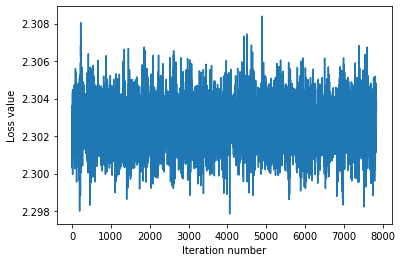

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()